In [27]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note_id,person_id,age,gender_source_value,BMI,admission_department,division,ward,asa_class,surgeon_id,...,condition_source_value,surgery_room,previous_surgery,emergency_status,op_timing,day_of_the_week,week_of_the_month,month,surgeon_estimated_op_time,surgery_duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3,September,130,82


In [28]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Calculating MAE, RMSE, MSE, and R² for the surgeon's estimated operation time
surgeon_mae = mean_absolute_error(df['surgery_duration'], df['surgeon_estimated_op_time'])
surgeon_rmse = np.sqrt(mean_squared_error(df['surgery_duration'], df['surgeon_estimated_op_time']))
surgeon_mse = mean_squared_error(df['surgery_duration'], df['surgeon_estimated_op_time'])
surgeon_r2 = r2_score(df['surgery_duration'], df['surgeon_estimated_op_time'])

surgeon_mae, surgeon_rmse, surgeon_mse, surgeon_r2

(70.8192520732668, 94.3469303146079, 8901.343259789479, 0.2590043404892589)

In [2]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note_id', 'person_id', 'surgeon_estimated_op_time', 'final_op_name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition_source_value', 'op_code', 'surgeon_id', 'ward', 'admission_department', 'surgery_room']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical_department', 'op_timing', 'month', 'anesthesia_type', 
                'day_of_the_week', 'asa_class', 'week_of_the_month', 
                'division', 'previous_surgery', 'emergency_status', 'gender_source_value']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery_duration", axis=1)
y_all = df_encoded["surgery_duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery_duration, Length: 128975, dtype: int64

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 분과별 데이터셋 준비
departments = df['surgical_department'].unique()
models = {}
predictions = {}

# 각 분과별 모델 훈련
for dept in departments:
    # 열 이름 조정
    dept_col_name = 'surgical_department_' + dept

    # 분과별 데이터 필터링
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery_duration', axis=1)
    y_dept = dept_data['surgery_duration']

    # 데이터 분할
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # 모델 훈련 (랜덤 포레스트 예시)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_dept, y_train_dept)
    models[dept] = model

    # 테스트 데이터셋에 대한 예측 수행
    predictions[dept] = model.predict(X_test_dept)

# 앙상블을 위한 준비
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# 각 분과별 모델을 전체 테스트 데이터셋에 적용
for dept, model in models.items():
    # 열 이름 조정
    dept_col_name = 'surgical_department_' + dept

    # 해당 분과에 해당하는 테스트 데이터 인덱스
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # 해당 분과의 예측값 계산
    dept_predictions = model.predict(X_test_all.loc[dept_indices])

    # 최종 예측 배열에 해당 부분 업데이트
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# 성능 평가
mae = mean_absolute_error(y_test_all, final_predictions)
rmse = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2 = r2_score(y_test_all, final_predictions)

print(f"Ensemble MAE: {mae}, RMSE: {rmse}, R²: {r2}")

Ensemble MAE: 16.67870301451433, RMSE: 31.662393537060968, R²: 0.9158268414503081


In [4]:
# Retraining the models with the optimized hyperparameters
optimized_models = {}
optimized_predictions = {}

for dept in departments:
    dept_col_name = 'surgical_department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    
    X_dept = dept_data.drop('surgery_duration', axis=1)
    y_dept = dept_data['surgery_duration']

    # Splitting the data for the department
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # Training the model with optimized hyperparameters
    optimized_model = RandomForestRegressor(n_estimators=300, max_depth=30, min_samples_split=5, random_state=42)
    optimized_model.fit(X_train_dept, y_train_dept)
    optimized_models[dept] = optimized_model

    # Predicting on the test set
    optimized_predictions[dept] = optimized_model.predict(X_test_dept)

# Preparing for ensemble predictions with optimized models
optimized_final_predictions = np.zeros(len(X_test_all))

# Applying department-wise optimized models to the whole test set
for dept, model in optimized_models.items():
    dept_col_name = 'surgical_department_' + dept
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index
    dept_optimized_predictions = model.predict(X_test_all.loc[dept_indices])
    optimized_final_predictions[np.isin(test_indices, dept_indices)] = dept_optimized_predictions

# Evaluating performance of the optimized models
optimized_mae = mean_absolute_error(y_test_all, optimized_final_predictions)
optimized_rmse = np.sqrt(mean_squared_error(y_test_all, optimized_final_predictions))
optimized_r2 = r2_score(y_test_all, optimized_final_predictions)

optimized_mae, optimized_rmse, optimized_r2


(18.699939668399423, 34.48922082411924, 0.9001258939611498)

In [5]:
# Retraining the models with the default parameters of RandomForestRegressor
default_models = {}
default_predictions = {}
default_mae = {}
dept_sample_counts = {}
actual_surgery_durations = {}

for dept in departments:
    dept_col_name = 'surgical_department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    
    # Storing the number of samples per department
    dept_sample_counts[dept] = len(dept_data)

    if len(dept_data) > 0:
        X_dept = dept_data.drop('surgery_duration', axis=1)
        y_dept = dept_data['surgery_duration']

        # Actual surgery durations for each department
        actual_surgery_durations[dept] = y_dept

        # Splitting the data for the department
        X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

        # Training the model with default parameters
        default_model = RandomForestRegressor(random_state=42)
        default_model.fit(X_train_dept, y_train_dept)
        default_models[dept] = default_model

        # Predicting on the test set
        dept_predictions = default_model.predict(X_test_dept)
        default_predictions[dept] = dept_predictions

        # Calculating MAE for each department
        dept_mae = mean_absolute_error(y_test_dept, dept_predictions)
        default_mae[dept] = dept_mae

# Preparing the data for visualization
dept_data_for_visualization = pd.DataFrame({
    'Department': default_mae.keys(),
    'MAE': default_mae.values(),
    'Sample Count': [dept_sample_counts[dept] for dept in default_mae.keys()],
    'Average Surgery Duration': [actual_surgery_durations[dept].mean() for dept in default_mae.keys()]
})

dept_data_for_visualization.sort_values(by='Department')

,Department,MAE,Sample Count,Average Surgery Duration
8,Cardiovascular Thoracic Surgery,49.312531,9341,233.352425
0,General Surgery,36.062333,36466,155.665771
7,Neurosurgery,50.865132,7187,239.383053
4,Obstetrics & Gynecology,34.729579,11510,131.534839
3,Ophthalmology,13.188377,17437,57.755921
2,Orthopedics,35.027960,16617,133.923572
1,Otolaryngology,46.074115,11772,139.036018
16,Pediatric Neurosurgery,67.894530,1166,296.249571
14,Pediatric Ophthalmology,10.492786,7857,56.627339
10,Pediatric Orthopedics,49.453355,3905,143.927017


C:\Users\SNUH\AppData\Local\Temp\ipykernel_13264\1165098147.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAE Percentage', y='Department', data=dept_data_for_visualization.sort_values('MAE Percentage', ascending=False), palette='viridis')


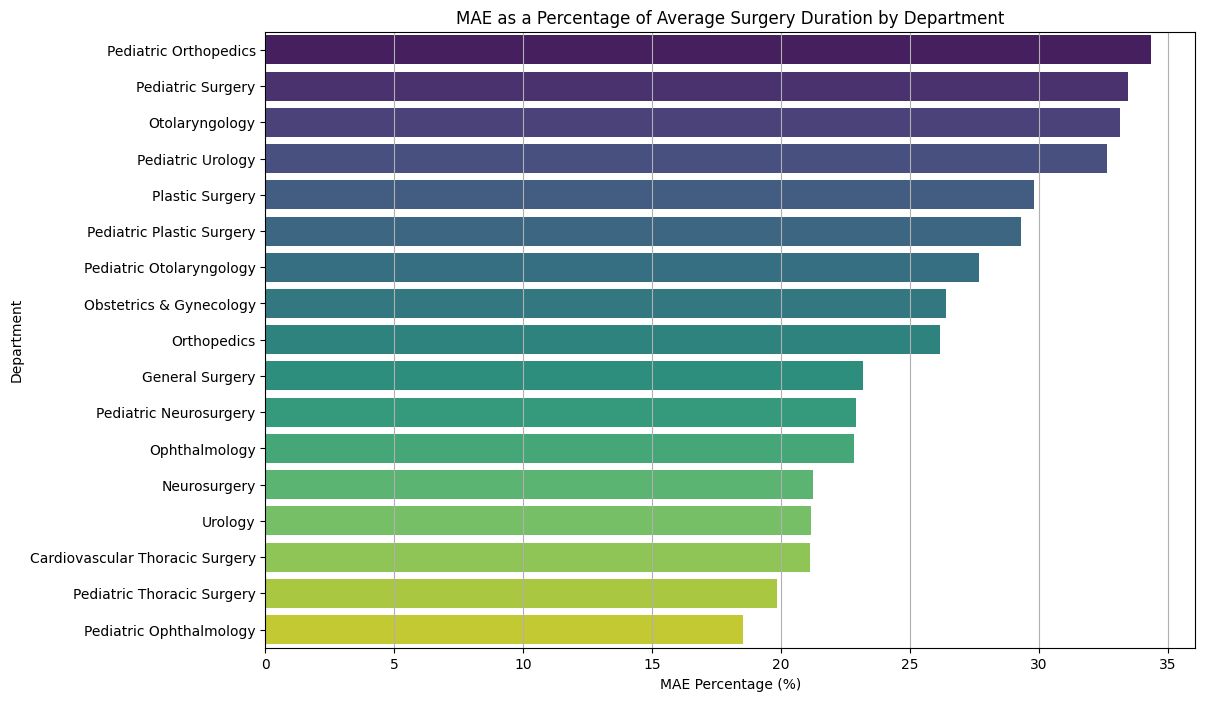

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculating the MAE as a percentage of the average surgery duration
dept_data_for_visualization['MAE Percentage'] = (dept_data_for_visualization['MAE'] / dept_data_for_visualization['Average Surgery Duration']) * 100

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='MAE Percentage', y='Department', data=dept_data_for_visualization.sort_values('MAE Percentage', ascending=False), palette='viridis')

plt.title('MAE as a Percentage of Average Surgery Duration by Department')
plt.xlabel('MAE Percentage (%)')
plt.ylabel('Department')
plt.grid(axis='x')
plt.show()



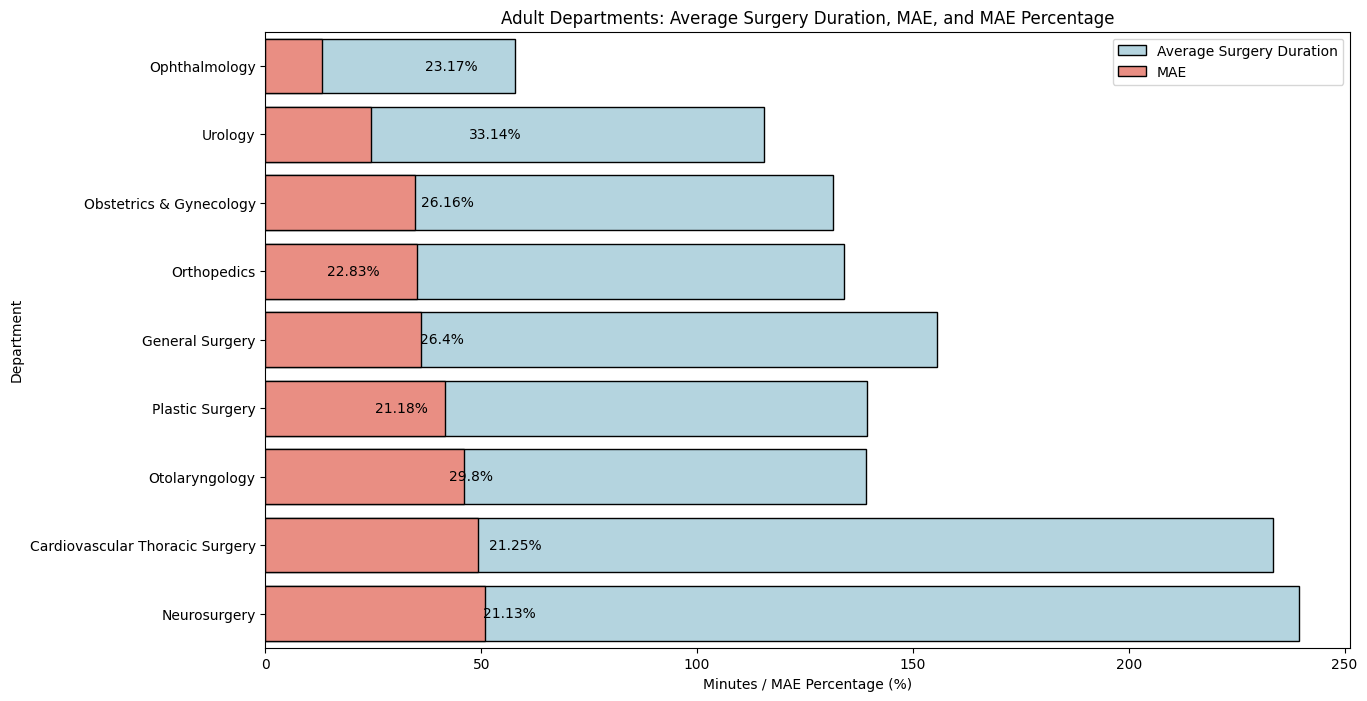

In [19]:
# Separating the departments into pediatric and adult categories
pediatric_data = sorted_dept_data[sorted_dept_data['Department'].str.startswith('Pediatric')]
adult_data = sorted_dept_data[~sorted_dept_data['Department'].str.startswith('Pediatric')]

# Plot for Adult Departments
plt.figure(figsize=(14, 8))
sns.barplot(x='Average Surgery Duration', y='Department', data=adult_data, color='lightblue', edgecolor='black', label='Average Surgery Duration')
sns.barplot(x='MAE', y='Department', data=adult_data, color='salmon', edgecolor='black', label='MAE')
for index, row in adult_data.iterrows():
    plt.text(row['MAE'] + 1, index, f"{round(row['MAE Percentage'], 2)}%", color='black', va='center', ha='left')
plt.title('Adult Departments: Average Surgery Duration, MAE, and MAE Percentage')
plt.xlabel('Minutes / MAE Percentage (%)')
plt.ylabel('Department')
plt.legend()
plt.show()

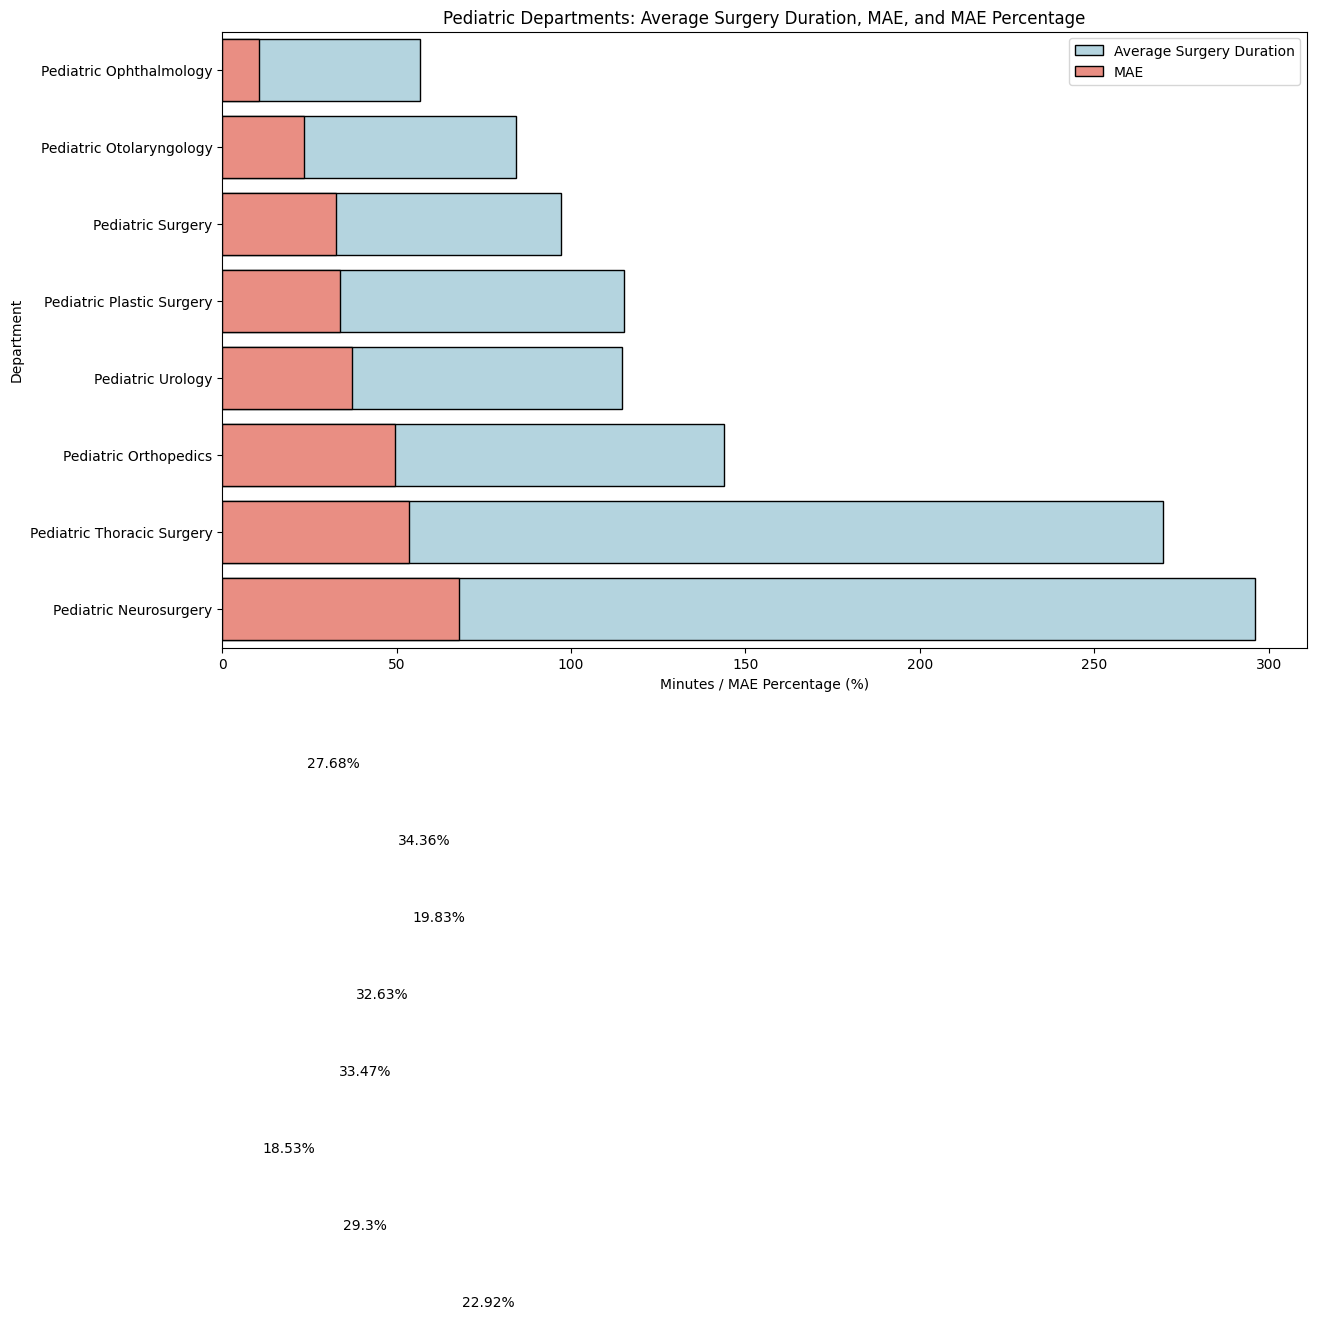

In [23]:
# Plot for Pediatric Departments
plt.figure(figsize=(14, 8))
sns.barplot(x='Average Surgery Duration', y='Department', data=pediatric_data, color='lightblue', edgecolor='black', label='Average Surgery Duration')
sns.barplot(x='MAE', y='Department', data=pediatric_data, color='salmon', edgecolor='black', label='MAE')
for index, row in pediatric_data.iterrows():
    plt.text(row['MAE'] + 1, index, f"{round(row['MAE Percentage'], 2)}%", color='black', va='center', ha='left')
plt.title('Pediatric Departments: Average Surgery Duration, MAE, and MAE Percentage')
plt.xlabel('Minutes / MAE Percentage (%)')
plt.ylabel('Department')
plt.legend()
plt.show()

In [24]:
# Training a model on the entire dataset
full_model = RandomForestRegressor(random_state=42)
full_model.fit(X_train_all, y_train_all)

# Predicting on the test set
full_model_predictions = full_model.predict(X_test_all)

# Evaluating the full model's performance
full_model_mae = mean_absolute_error(y_test_all, full_model_predictions)
full_model_rmse = np.sqrt(mean_squared_error(y_test_all, full_model_predictions))
full_model_r2 = r2_score(y_test_all, full_model_predictions)

full_model_mae, full_model_rmse, full_model_r2


(34.04604403920109, 57.451605225030455, 0.7228655762174734)

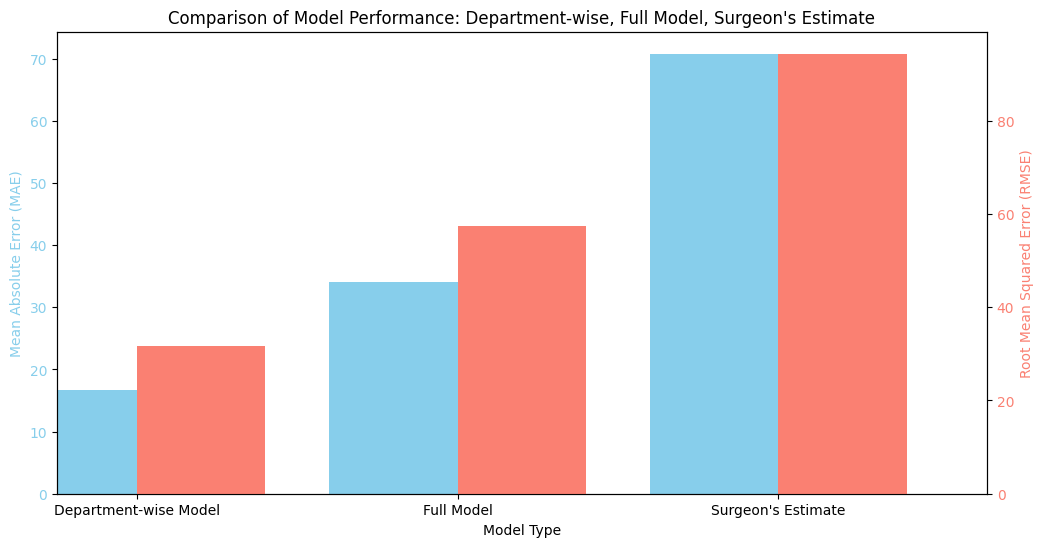

,MAE,RMSE
Model Type,,
Department-wise Model,16.678703,31.662394
Full Model,34.046044,57.451605
Surgeon's Estimate,70.819252,94.346930


In [35]:
import matplotlib.pyplot as plt

# Preparing data for comparison plot and table
comparison_data = {
    "Model Type": ["Department-wise Model", "Full Model", "Surgeon's Estimate"],
    "MAE": [mae, full_model_mae, surgeon_mae],
    "RMSE": [rmse, full_model_rmse, surgeon_rmse]
}

# Creating a DataFrame for easy plotting
comparison_df = pd.DataFrame(comparison_data)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for MAE
comparison_df.plot(kind='bar', x='Model Type', y='MAE', ax=ax1, color='skyblue', position=1, width=0.4, legend=False)
ax1.set_ylabel('Mean Absolute Error (MAE)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(comparison_df['Model Type'], rotation=0)  # Set x-axis labels horizontally

# Creating a second y-axis for RMSE
ax2 = ax1.twinx()
comparison_df.plot(kind='bar', x='Model Type', y='RMSE', ax=ax2, color='salmon', position=0, width=0.4, legend=False)
ax2.set_ylabel('Root Mean Squared Error (RMSE)', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')
ax2.set_xticklabels(comparison_df['Model Type'], rotation=0)  # Set x-axis labels horizontally

# Title and labels
plt.title('Comparison of Model Performance: Department-wise, Full Model, Surgeon\'s Estimate')
ax1.set_xlabel('Model Type')

plt.show()
# Creating a table for comparison
comparison_table = comparison_df.set_index('Model Type')
comparison_table
